# SHAP (Shapely Additive explanation)

Calculates Shapely values from game theory to estimate the contribution of each feature to a given output of the model. 

In [1]:
import xarray as xr
import netCDF4
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
import gc
import geopandas as gpd
import rioxarray as rxr
from shapely.geometry import box
from affine import Affine
import sys
import seaborn as sns
import rasterio
import os
from collections import defaultdict
import random
from methods.shap import Shap
from utils.utils import print_instance
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_precision_recall_curve

In [2]:
import warnings
warnings.filterwarnings('ignore')

Upload UC3 data: 

In [3]:
df = pd.read_csv(r"C:\Users\unknown\Desktop\repos\DC\data\greece_pixel_dataset.csv")

In [4]:
list(df.columns)

['Fpar_500m',
 'Lai_500m',
 'LST_Day_1km',
 'LST_Night_1km',
 '1 km 16 days NDVI',
 '1 km 16 days EVI',
 'ET_500m',
 'LE_500m',
 'PET_500m',
 'PLE_500m',
 'era5_max_u10',
 'era5_max_v10',
 'era5_max_t2m',
 'era5_max_tp',
 'era5_min_u10',
 'era5_min_v10',
 'era5_min_t2m',
 'era5_min_tp',
 'x',
 'y',
 'dem_mean',
 'dem_std',
 'aspect_mean',
 'aspect_std',
 'slope_mean',
 'slope_std',
 'roads_density_2020',
 'population_density',
 'clc',
 'burned_areas',
 'time',
 'datetime']

In [5]:
features = [
 'Fpar_500m',
 'Lai_500m',
 'LST_Day_1km',
 'LST_Night_1km',
 '1 km 16 days NDVI',
 '1 km 16 days EVI',
 'ET_500m',
 'LE_500m',
 'PET_500m',
 'PLE_500m',
 'era5_max_u10',
 'era5_max_v10',
 'era5_max_t2m',
 'era5_max_tp',
 'era5_min_u10',
 'era5_min_v10',
 'era5_min_t2m',
 'era5_min_tp'
]

coordinates = ['x', 'y']

static_features = [ 
 'dem_mean',
 'dem_std',
 'aspect_mean',
 'aspect_std',
 'slope_mean',
 'slope_std',
 'roads_density_2020',
 'population_density',
 'clc'
]

target = 'burned_areas'

Data cleaning and train-test splitting: 

In [6]:
nan_fillvalue = -9999
df = df.fillna(nan_fillvalue)
time_split = int(df.time.max()*0.85)
train_df=df[df['time']<time_split]
test_df=df[df['time']>=time_split]

Fit a Random Forest and plot results: 

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.91      2050
         1.0       0.73      0.61      0.66       634

    accuracy                           0.85      2684
   macro avg       0.81      0.77      0.78      2684
weighted avg       0.85      0.85      0.85      2684



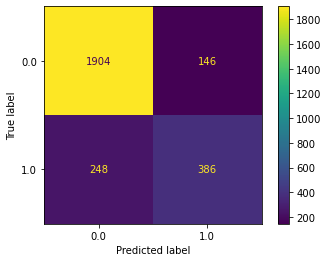

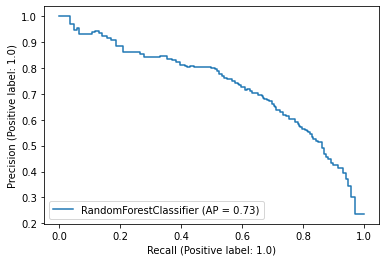

In [7]:
features_to_exclude = [
 'Fpar_500m',
 'Lai_500m',
#  'LST_Day_1km',
#  'LST_Night_1km',
#  '1 km 16 days NDVI',
#  '1 km 16 days EVI',
 'ET_500m',
 'LE_500m',
 'PET_500m',
 'PLE_500m',
#  'era5_max_u10',
#  'era5_max_v10',
#  'era5_max_t2m',
#  'era5_max_tp',
 'era5_min_u10',
 'era5_min_v10',
 'era5_min_t2m',
 'era5_min_tp',
#  'dem_mean',
 'dem_std',
#  'aspect_mean',
 'aspect_std',
#  'slope_mean',
#  'slope_std',
#  'roads_density_2020',
#  'population_density',
#  'clc'
]
features_filtered = [x for x in features + static_features if x not in features_to_exclude]

X_train, X_test = train_df[features_filtered], test_df[features_filtered]
y_train, y_test = train_df[target], test_df[target]
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

plot_confusion_matrix(clf, X_test, y_test)
plt.show()
plot_precision_recall_curve(clf, X_test, y_test)  
plt.show()

Let us now fit the SHAP method in order to explain the prediction for the first test instance: 

In [8]:
X_train = X_train[X_train!= nan_fillvalue].dropna()
X_test = X_test[X_test!= nan_fillvalue].dropna()

In [9]:
config = {
    "model": clf,
    "X": X_train, 
    "features": features_filtered,
    "predictor":"LST_Day_1km",
    "Xtest": X_test, 
    "instance": 0,
    "plot": ["local", "waterfall"]
}

In [10]:
sp = Shap(config)
explainer, shapely, _, _ = sp.fit()

Instance number :  baseline
LST_Day_1km  =  307.3
LST_Night_1km  =  293.82
1 km 16 days NDVI  =  48830000.0
1 km 16 days EVI  =  28970000.0
era5_max_u10  =  1.1757861
era5_max_v10  =  0.007633567
era5_max_t2m  =  302.32333
era5_max_tp  =  0.0
dem_mean  =  337.77533
aspect_mean  =  176.48358
slope_mean  =  10.986203
slope_std  =  5.598031
roads_density_2020  =  4.0
population_density  =  10.93496
clc  =  25.0


Permutation explainer: 709it [03:39,  3.17it/s]                                                                        


Let us print the explanation for the following instance:

In [11]:
print_instance(np.array(X_test)[0,:], features_filtered, 0)

Instance number :  0
LST_Day_1km  =  280.0
LST_Night_1km  =  276.86
1 km 16 days NDVI  =  63910000.0
1 km 16 days EVI  =  32640000.0
era5_max_u10  =  3.1420028
era5_max_v10  =  0.47091043
era5_max_t2m  =  285.39655
era5_max_tp  =  0.00013382733
dem_mean  =  922.5156
aspect_mean  =  225.84392
slope_mean  =  12.675943
slope_std  =  4.7079496
roads_density_2020  =  2.0
population_density  =  3.3826084
clc  =  29.0


In [12]:
clf.predict_proba(np.array(X_test)[0,:].reshape(1,-1))

array([[0.99, 0.01]])

In [13]:
print("Ground truth = ", np.array(y_test)[0])

Ground truth =  0.0


Local explanation for specified sample, i.e. shapely values per feature giving positive or negative contribution with respect to the model prediction on the baseline sample (e.g. the mean):

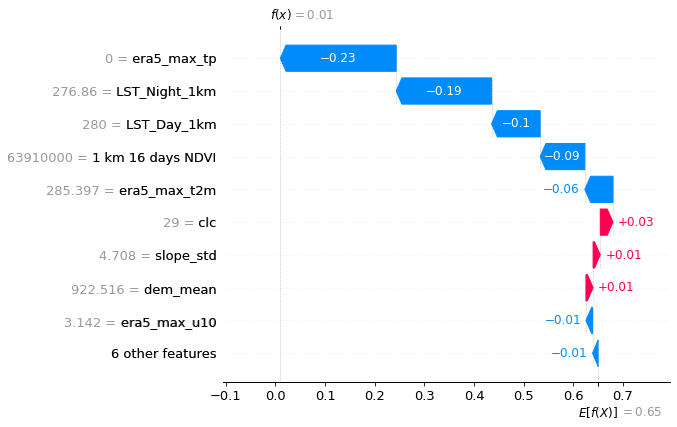

In [14]:
sp.plot(explainer, shapely, ["local", "waterfall"], 0)

Model prediction over the whole test set and corresponding shapely values, black bars on the right side gives an overall feature importance: 

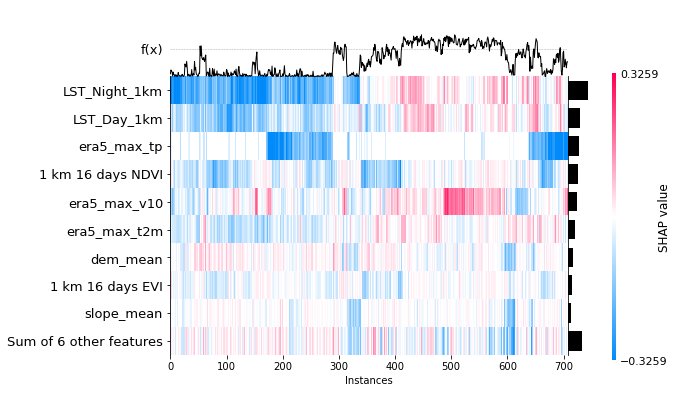

In [15]:
sp.plot(explainer, shapely, ["global", "heatmap"], 0)

Scatter plot of the shapely value of the predictor specified: 

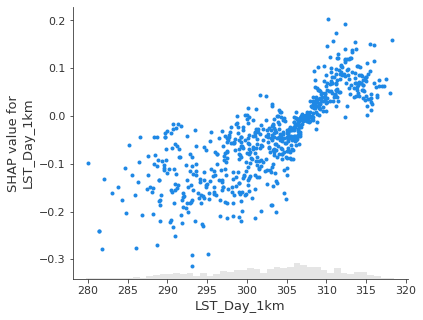

In [16]:
sp.plot(explainer, shapely, ["global", "scatter"], 0)

Plot the shapely values per feature per data point:

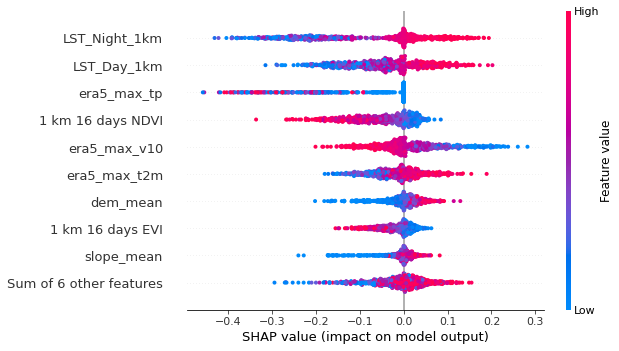

In [17]:
sp.plot(explainer, shapely, ["global", "beeswarm"], 0)

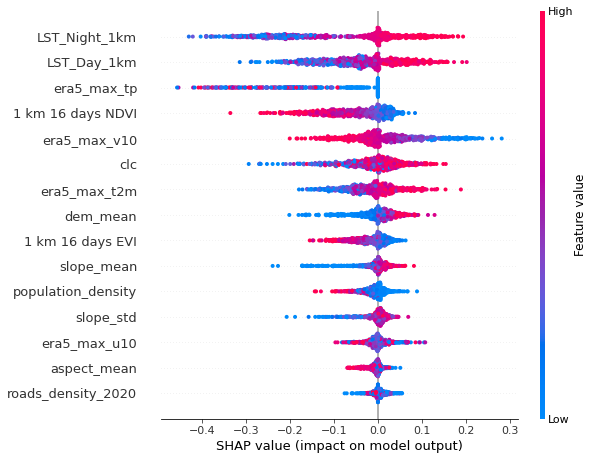

In [18]:
sp.plot(explainer, shapely, ["global", "summary"], 0)

Mean shapely value per feature over the test set provides an estimate for the feature importance:

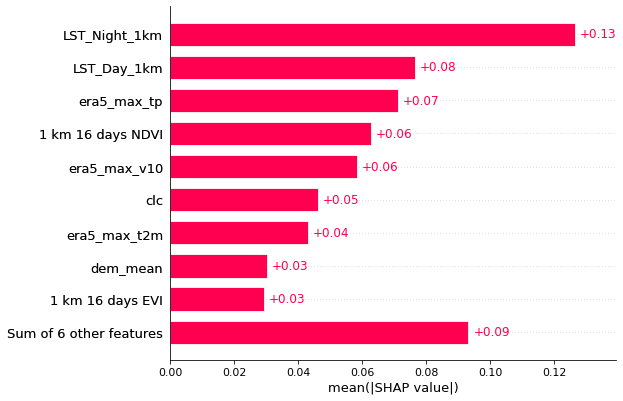

In [19]:
sp.plot(explainer, shapely, ["global", "bar"], 0)

We can also call the run_all() method if we want to fit the SHAP algorithm and show the results at the same time:

Instance number :  baseline
LST_Day_1km  =  307.3
LST_Night_1km  =  293.82
1 km 16 days NDVI  =  48830000.0
1 km 16 days EVI  =  28970000.0
era5_max_u10  =  1.1757861
era5_max_v10  =  0.007633567
era5_max_t2m  =  302.32333
era5_max_tp  =  0.0
dem_mean  =  337.77533
aspect_mean  =  176.48358
slope_mean  =  10.986203
slope_std  =  5.598031
roads_density_2020  =  4.0
population_density  =  10.93496
clc  =  25.0


Permutation explainer: 709it [03:34,  3.13it/s]                                                                        


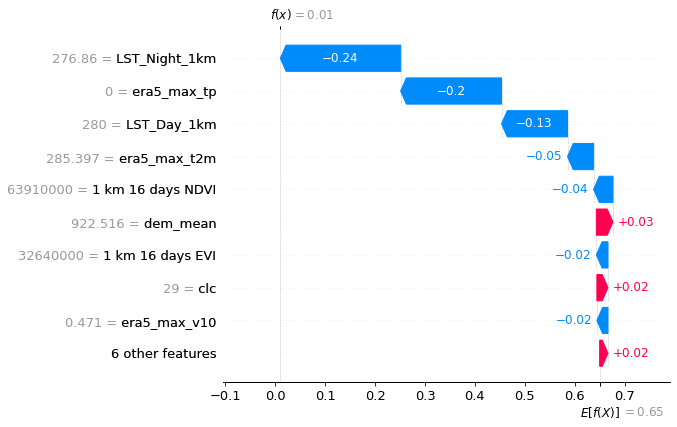

In [20]:
sp.run_all()